# Data Collection and preprocessing

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
import geopandas as gpd
import pandas as pd

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

In [ ]:
from utils.geography_helpers import create_rotated_square_aoi

# Set bounding box for the area of interest (AOI) in Gaxa City
create_rotated_square_aoi(
    lat=31.513,
    lon=34.46,
    size_km=6,
    angle_deg=48, 
    filename="../utils/AOI_bboxes/aoi_shifa.geojson"
)

# Set bounding box for second area of interest (AOI) in Khan Younis
create_rotated_square_aoi(
    lat=31.3435,
    lon=34.3040,
    size_km=3,
    angle_deg=0, 
    filename="../utils/AOI_bboxes/aoi_khan_younis.geojson"
)

gdf = gpd.read_file("../utils/AOI_bboxes/aoi_shifa.geojson")
print(gdf.geometry[0].wkt)

POLYGON ((34.4620003843005 31.474830393734155, 34.49816960626585 31.515000384300503, 34.4579996156995 31.551169606265848, 34.421830393734155 31.5109996156995, 34.4620003843005 31.474830393734155))


## A/ Sentinel-1 data


The idea here is to download 10 pre-conflict (reference) and 6 post-conflict (post) images of Sentinel-1 (GRD-HD; Polarization: VV+VH).

The images will be distinguished depending on the orbit: Ascending and Descending.

The product urls from [ASF Data Search Vertex](https://search.asf.alaska.edu) are available at `data/sentinel_file_urls.csv`

Some dates:
- Collection period for reference images: 05 October 2022 - 25 October 2023
- Start of the Siege of Gaza: 02 November 2023
- Collection period for post-conflict images: 05 November 2023 - 10 February 2024

Importantly, UNOSAT labels are dated from 26 November 2023, so post-conflict images before that will not be considered. 

Each image will undergo and process of 
1. Subsetting: to only keep the area of interest in Gaza City
2. Preprocessing:
    - orbit correction
    - border and thermal noise removal
    - radiometric calibration
    - terrain correction

The script that downloads one product (zip) is ran with:

```console
python scripts/download_single_sentinel_file.py <url>
```

The script that preprocessed the resulting zip is ran with:

```console
python preprocess_single_sentinel_zip.py <path/to/zipfile.zip> <path/to/aoi.geojson> <output_directory> <path/to/snap/gpt>
```

Both scripts have been combined in the `download_process_single_sentinel_file.py` script.

For one URL, the downloading, preprocessing (and deletion of raw file) is done by running:

```console
cd scripts

python download_process_single_sentinel_file.py <url.zip> ../utils/AOI_bboxes/aoi_shifa.geojson ../data/preprocessed/sentinel --snap_gpt_path /Applications/esa-snap/bin/gpt
```

For all the URLs, run the cells in `scripts/download_process_sentinel.ipynb`

## B/ UNOSAT labels

The script in `scripts/download_footprints_UNOSAT` automates the data collection of:

-  building footprings from [Ballinger (2024)](https://github.com/oballinger/PWTT/tree/main?tab=readme-ov-file)
- building damage labels from [UNOSAT](https://unosat.org/products/4047).  

```console
python scripts/download_footprints_UNOSAT
```
 will fetch the data online and save it to `data/raw`.

In [4]:
from utils.preprocessing_UNOSAT_helpers import (
    list_gdb_layers,
    load_unosat_damage_sites,
    process_unosat_damage_labels, 
    create_control_points
)

gdb_path = "../data/raw/labels/UNOSAT_GazaStrip_CDA_25February2025.gdb"
layers = list_gdb_layers(gdb_path)
layer_name = "Damage_Sites_GazaStrip_20250225"
# output_path = "../data/raw/labels/gaza_unosat_labels.geojson"

print(f"\nLayers in the GDB ({len(layers)} layers):")
for i, layer in enumerate(layers):
    print(f"{i+1}. {layer}")

# Load all layers
damage_data = load_unosat_damage_sites()


Layers in the GDB (5 layers):
1. Damage_Sites_GazaStrip_20250225
2. fras_aux_IDP_Sites_Template_FC
3. fras_blk_IDP_Sites_Template_FC
4. fras_bnd_IDP_Sites_Template_FC
5. fras_ras_IDP_Sites_Template_FC
Loading UNOSAT data from: /Users/matteolarrode/Documents/Oxford/Applied ML/Summative/ML-BuildingDamageViaSatellite/data/raw/labels/UNOSAT_GazaStrip_CDA_25February2025.gdb
Loading layer: Damage_Sites_GazaStrip_20250225
Loaded layer 'Damage_Sites_GazaStrip_20250225' with 173350 features
Successfully loaded 173350 damage points

Columns in the damage data:
 - SiteID
 - SensorDate
 - SensorID
 - ConfidenceID
 - Main_Damage_Site_Class
 - SensorDate_2
 - SensorID_2
 - ConfidenceID_2
 - Main_Damage_Site_Class_2
 - Damage_Status_2
 - SensorDate_3
 - SensorID_3
 - ConfidenceID_3
 - Main_Damage_Site_Class_3
 - Damage_Status_3
 - SensorDate_4
 - SensorID_4
 - ConfidenceID_4
 - Main_Damage_Site_Class_4
 - Damage_Status_4
 - SensorDate_5
 - SensorID_5
 - ConfidenceID_5
 - Main_Damage_Site_Class_5
 - 

In [ ]:
# Process the damage labels for November 26, 2023 (date index 3)
# Only keeping Destroyed and Severe Damage as positive examples
damage_labels = process_unosat_damage_labels(
    gdf=damage_data, 
    date_index=3,     # Index 3 corresponds to November 26, 2023
    aoi_path="../utils/AOI_bboxes/aoi_shifa.geojson",  # Your AOI
    positive_classes=[1, 2],  # Only 1=Destroyed and 2=Severe Damage are positive
    include_moderate=False    # Don't include moderate damage in the dataset
)

Processing UNOSAT damage labels for date index 3...
Found 55215 valid damage labels for date index 3
Date: 2023-11-26 00:00:00+00:00
Filtered from 55215 to 17700 points (keeping only Destroyed, Severe Damage, and No Visible Damage)
Filtering by AOI: ../utils/AOI_bboxes/aoi_shifa.geojson
Filtered from 17700 to 4224 points within the AOI
Saved processed labels to ../data/processed/labels/damage_labels_20231126.gpkg
Saved CSV version to ../data/processed/labels/damage_labels_20231126.csv

Damage class distribution:
  Severe Damage: 2279 (54.0%)
  Destroyed: 1945 (46.0%)

Total damaged structures: 4224 (100.0%)
Total undamaged structures: 0 (0.0%)


In [11]:
# Create negative control points
# NOTE: Need to have updated the buildings_witin_aoi.gpkg file
control_points = create_control_points(
    damage_labels=damage_labels,
    aoi_path="../utils/AOI_bboxes/aoi_shifa.geojson",
    buildings_path="../data/preprocessed/footprints/buildings_within_aoi.gpkg",
    min_distance=30,  # 30m away from damage points
    num_points=len(damage_labels)  # Create the same number as damage points
)

Generating 4224 control points at least 30m from damage...
Loading building footprints...
Found 46701 buildings within AOI
Creating damage buffer zone...
Found 31257 buildings outside damage buffer
Generating control points from building centroids...
Generated 4224 control points within buildings


Text(0.5, 1.0, 'Damage and Control Points')

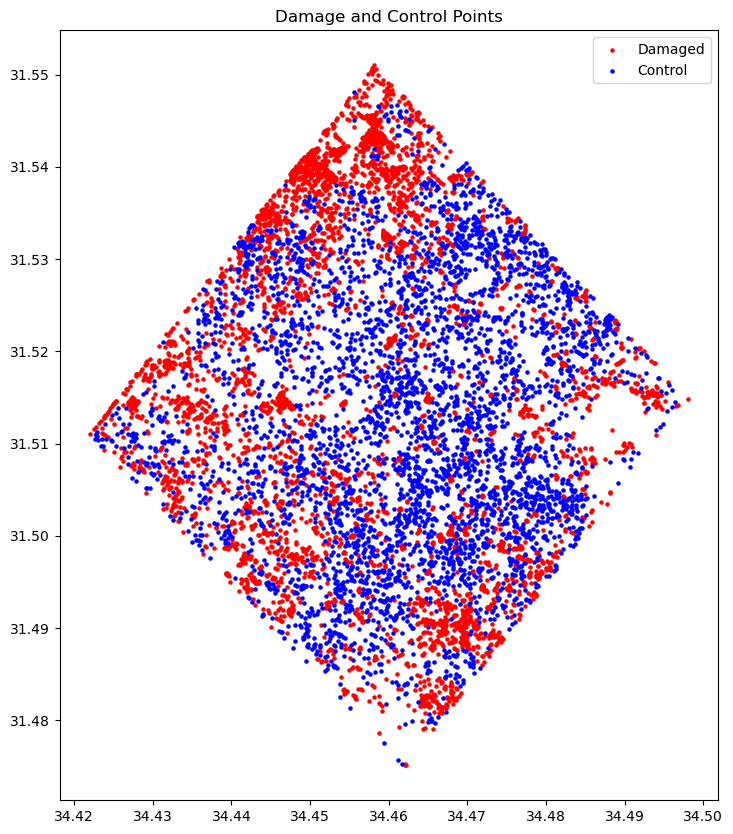

In [12]:
# Visualize the points
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 10))
damage_labels.plot(ax=ax, color='red', markersize=5, label='Damaged')
control_points.plot(ax=ax, color='blue', markersize=5, label='Control')
ax.legend()
plt.title('Damage and Control Points')

Saved combined points to ../data/processed/labels/combined_damage_control_points.gpkg
Saved CSV version to ../data/processed/labels/combined_damage_control_points.csv

Total points: 8448
Points by class:
is_damaged
1    4224
0    4224
Name: count, dtype: int64

Points by damage class:
damage_class_desc
No Visible Damage    4224
Severe Damage        2279
Destroyed            1945
Name: count, dtype: int64


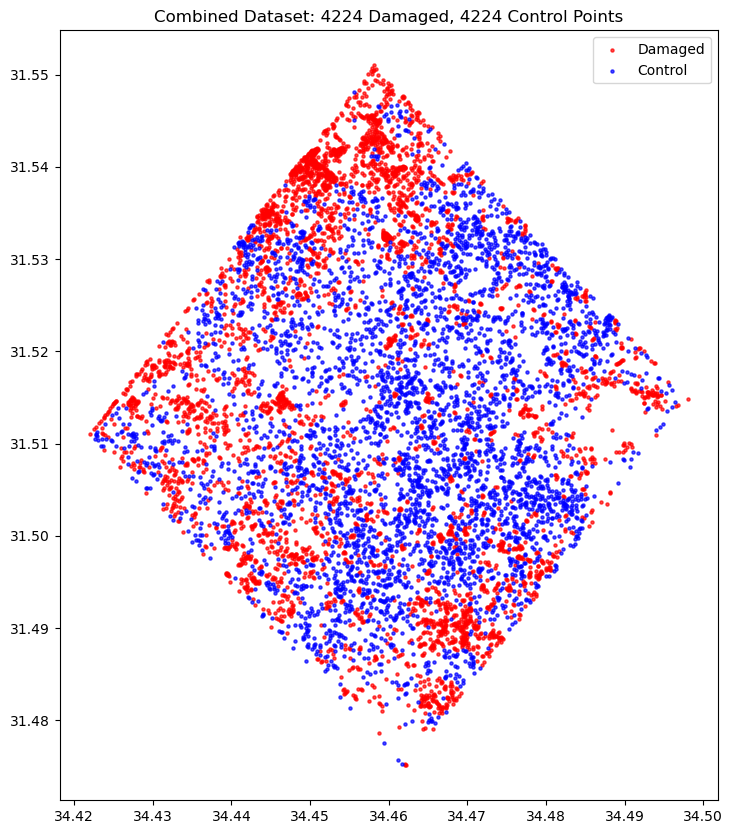

In [13]:
# Combine damage_labels and control_points into a single GeoDataFrame
# Make sure all required columns are in both datasets
required_columns = ['geometry', 'is_damaged', 'damage_class', 'damage_class_desc', 'lon', 'lat']

# Check if control_points has all required columns
for col in required_columns:
    if col not in control_points.columns:
        if col == 'damage_class':
            control_points['damage_class'] = 6  # No Visible Damage
        elif col == 'damage_class_desc':
            control_points['damage_class_desc'] = 'No Visible Damage'
        elif col == 'is_damaged':
            control_points['is_damaged'] = 0
        elif col in ['lon', 'lat'] and 'geometry' in control_points.columns:
            control_points['lon'] = control_points.geometry.x
            control_points['lat'] = control_points.geometry.y

# Same check for damage_labels (just to be safe)
for col in required_columns:
    if col not in damage_labels.columns:
        if col in ['lon', 'lat'] and 'geometry' in damage_labels.columns:
            damage_labels['lon'] = damage_labels.geometry.x
            damage_labels['lat'] = damage_labels.geometry.y

# Combine the dataframes
combined_points = pd.concat([damage_labels, control_points], ignore_index=True)

# Make sure the result is a GeoDataFrame
combined_points = gpd.GeoDataFrame(combined_points, geometry='geometry', crs=damage_labels.crs)

# Visualize the combined points
fig, ax = plt.subplots(figsize=(12, 10))
damage_points = combined_points[combined_points['is_damaged'] == 1]
control_points = combined_points[combined_points['is_damaged'] == 0]

damage_points.plot(ax=ax, color='red', markersize=5, alpha=0.7, label='Damaged')
control_points.plot(ax=ax, color='blue', markersize=5, alpha=0.7, label='Control')
ax.legend()
plt.title(f'Combined Dataset: {len(damage_points)} Damaged, {len(control_points)} Control Points')

# Save the combined GeoDataFrame
output_path = '../data/processed/labels/combined_damage_control_points.gpkg'
combined_points.to_file(output_path, driver='GPKG')
print(f"Saved combined points to {output_path}")

# Also save as CSV for easier use
csv_path = '../data/processed/labels/combined_damage_control_points.csv'
combined_points.drop(columns=['geometry']).to_csv(csv_path, index=False)
print(f"Saved CSV version to {csv_path}")

# Display basic statistics
print(f"\nTotal points: {len(combined_points)}")
print("Points by class:")
print(combined_points['is_damaged'].value_counts())

print("\nPoints by damage class:")
print(combined_points['damage_class_desc'].value_counts())

## C/ Building footprints

The script in `scripts/download_footprints_UNOSAT` automates the data collection of:

-  building footprings from [Ballinger (2024)](https://github.com/oballinger/PWTT/tree/main?tab=readme-ov-file)
- building damage labels from [UNOSAT](https://unosat.org/products/4047).  

```console
python scripts/download_footprints_UNOSAT
```
 will fetch the data online and save it to `data/raw`.

In [8]:
import pandas as pd
import json
from shapely.geometry import Polygon, shape
import matplotlib.pyplot as plt

# Load the building footprints data
print("Loading building footprints data...")
footprints_path = "../data/raw/building_data/footprints/Gaza_20240503_1_footprints.csv"

# Parse the .geo column which contains GeoJSON data
def parse_geojson(geo_str):
    try:
        return shape(json.loads(geo_str))
    except:
        return None

# Read the CSV and parse the geometry column
buildings_df = pd.read_csv(footprints_path)
buildings_df['geometry'] = buildings_df['.geo'].apply(parse_geojson)

# Remove rows with invalid geometries
buildings_df = buildings_df.dropna(subset=['geometry'])

# Convert to GeoDataFrame
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry='geometry', crs="EPSG:4326")

Loading building footprints data...


/var/folders/r4/hzh5vjhs64sfqz3fgg0md4x80000gn/T/ipykernel_9540/29986271.py:18: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  buildings_df = pd.read_csv(footprints_path)


In [9]:
# Load AOI
print("Loading AOI...")
aoi_path = "../utils/AOI_bboxes/aoi_shifa.geojson"
aoi = gpd.read_file(aoi_path)

# Make sure CRS matches
if buildings_gdf.crs != aoi.crs:
    print(f"Converting AOI from {aoi.crs} to {buildings_gdf.crs}")
    aoi = aoi.to_crs(buildings_gdf.crs)

# Perform spatial intersection to keep only buildings within AOI
print("Filtering buildings within AOI...")
buildings_in_aoi = gpd.sjoin(buildings_gdf, aoi, predicate='within')

print(f"Found {len(buildings_in_aoi)} buildings within the AOI out of {len(buildings_gdf)} total buildings")


Loading AOI...
Filtering buildings within AOI...
Found 46701 buildings within the AOI out of 228730 total buildings


In [10]:
# Save the filtered dataset
output_path = "../data/preprocessed/footprints/buildings_within_aoi.gpkg"
buildings_in_aoi.to_file(output_path, driver="GPKG")
print(f"Saved filtered buildings to {output_path}")

Saved filtered buildings to ../data/preprocessed/footprints/buildings_within_aoi.gpkg
